# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import numpy as np
import pandas as pd

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_test.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params['reference_gene_filename']

# Template experiment ID
project_id = params['project_id']

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params['shared_genes_filename']

# Output files of recount2 template experiment data
raw_template_filename = params['raw_template_filename']
mapped_template_filename = params['mapped_template_filename']
processed_template_filename = params['processed_template_filename']

# Output files of recount2 compendium data
raw_compendium_filename = params['raw_compendium_filename']
mapped_compendium_filename = params['mapped_compendium_filename']
normalized_compendium_filename = params['normalized_compendium_filename']

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params['scaler_filename']

## Test: Downloading data

In [3]:
# Directory where the downloaded files of template experiment will be saved into
template_download_dir = os.path.join(local_dir, "template_download")

# Make sure this directory already exists
os.makedirs(template_download_dir, exist_ok=True)

In [4]:
%%R -i project_id -i template_download_dir -i raw_template_filename -i base_dir

source(paste(base_dir, '/generic_expression_patterns_modules/download_recount2_data.R'))

get_recount2_template_experiment(project_id, template_download_dir, raw_template_filename)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x

Loading objects:
  rse_gene


## Test: Renaming gene ids

In [5]:
# File mapping ensembl ids to hgnc symbols
gene_id_filename = os.path.join(base_dir, dataset_name, "data", "metadata", "ensembl_hgnc_mapping.tsv")

In [6]:
%%R -i raw_template_filename -i gene_id_filename -i base_dir

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)
# Input: raw_template_filename, output: gene_id_filename

source(paste(base_dir, '/generic_expression_patterns_modules/process_names.R'))

# Note: This mapping file from ensembl ids to hgnc symbols is based on the library("biomaRt")
# that gets updated. In order to get the most up-to-date version, you can delete the 
# ensembl_hgnc_mapping file to re-run the script that generates this mapping.

if (file.exists(gene_id_filename) == FALSE) {
    get_ensembl_symbol_mapping(raw_template_filename, gene_id_filename)
}

## Test: processing template data
This step will map the ensembl gene IDs in raw template data file to hgnc gene symbols, and delete certain columns (genes) and rows (samples). 

Output files generated in this step: 
- `shared_genes_filename`: pickled list of shared genes (created only if it doesn't exist yet)
- `mapped_template_filename`: template data with column names mapped to hgnc gene symbols
- `processed_template_filename`: template data with some sample rows dropped

In [7]:
manual_mapping = {                                                                                  
    "ENSG00000187510.7": "PLEKHG7",       
    "ENSG00000230417.11": "LINC00595",                      
    "ENSG00000276085.1": "CCL3L1",                     
    "ENSG00000255374.3": "TAS2R45",                       
}

# metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

process.process_raw_template_recount2(
    raw_template_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    shared_genes_filename,
    mapped_template_filename,
    sample_id_metadata_filename,
    processed_template_filename
)

In [8]:
# Read data
template_data = pd.read_csv(
    processed_template_filename,
    header=0,
    sep='\t',
    index_col=0
)

# Check samples dropped
print(template_data.shape)
assert(template_data.shape[0] == 24)
template_data.head()

(24, 17788)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
SRR493937,244,396,6,144077,2089,7,946,7,941,752,...,290,214,161,202,569,1618,9,768,12758,5060
SRR493938,230,384,8,142807,2062,8,968,3,978,776,...,276,219,171,215,576,1655,7,808,12925,5061
SRR493939,308,396,11,77651,1064,4,321,2,1633,1518,...,675,345,372,198,387,1315,30,842,4339,3304
SRR493940,303,351,13,77739,1125,12,325,0,1637,1481,...,650,318,317,155,448,1322,36,795,4400,3308
SRR493941,203,327,0,235645,2438,6,945,15,1520,1027,...,343,191,71,240,533,2006,4,1331,14318,4776


## Test: Processing compendium

In [9]:
process.process_raw_compendium_recount2(
    raw_compendium_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    shared_genes_filename,
    mapped_compendium_filename,
    normalized_compendium_filename, 
    scaler_filename
)

In [10]:
# Check number of genes is equal between the compendium and the template
compendium_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
assert(compendium_data.shape[1] == template_data.shape[1])

## Train: VAE training and reproducibility

In [11]:
# Create VAE directories
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs")
]
NN_architecture = params['NN_architecture']

for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(new_dir, exist_ok=True)

input dataset contains 92 samples and 17788 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 83 samples, validate on 9 samples
Epoch 1/5
83/83 [==============================] - 22s 265ms/step - loss: 9222.2171 - val_loss: 48174.9002
Epoch 2/5
83/83 [==============================] - 21s 257ms/step - loss: 8229.2984 - val_loss: 14346.2070
Epoch 3/5
83/83 [==============================] - 21s 257ms/step - loss: 7948.6427 - val_loss: 11616.0153
Epoch 4/5
83/83 [==============================] - 22s 259ms/step - loss: 7981.0901 - val_loss: 10882.5771
Epoch 5/5
83/83 [==============================] - 21s 257ms/step - loss: 8039.5536 - val_loss: 10668.8965


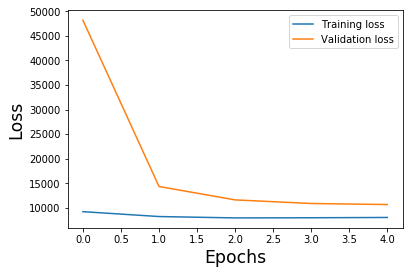

In [14]:
# Train VAE on new compendium data
train_vae_modules.train_vae(
    config_filename,
    normalized_compendium_filename
)

In [15]:
# Test reproducibility
expected_log = "data/test_vae_logs.tsv"
actual_log = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert np.all(
    np.isclose(
        pd.read_csv(expected_log, sep="\t").values,
        pd.read_csv(actual_log, sep="\t").values
    )
)